In [1]:
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
data = yf.Ticker("GOOG")
data = data.history(period="max")

data = data.loc["2010-01-01":].copy()

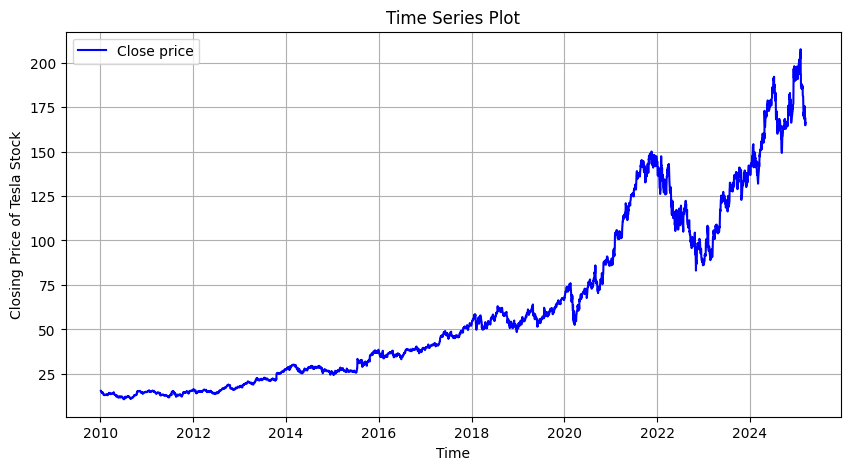

In [7]:
plt.figure(figsize=(10, 5))  
plt.plot(data.index, data['Close'], label='Close price', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel('Closing Price of Tesla Stock')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [8]:
data["Tomorrow"] = data["Close"].shift(-1)

# Does the stock price from day n to day n+1 increase?
data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)

#### Basic first model

In [10]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

# These inputs don't give much information, we want to know the relative changes, not just the values
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
# Compare predictions to actual results
precision_score(test["Target"], preds)

0.5614035087719298

In [ ]:
def predict(train, test, predictors, model):
    # Train model, predict and compare output to actual result
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=1000, step=125):
    # Use 4 years of data to predict next 6 month and then continuously add 6 month to the training 
    # [0, 1000) -> [1000, 1100)
    # [0, 1100) -> [1100, 1200)
    # [0, 1200) -> [1200, 1300)
    # ...
    # In the end we have the predictions [1000, end]
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
predictions = backtest(data, model, predictors)

In [15]:
predictions["Predictions"].value_counts()

Predictions
0    1557
1    1266
Name: count, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5268562401263823

In [21]:
# Relative number of appearances
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534892
0    0.465108
Name: count, dtype: float64

#### Improved model

In [22]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    # Compare stock price of today with the (mean) one over 2 days, last week, ... periods
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["Close"] / rolling_averages["Close"]
    
    # Trend is number of days in past x days where the stock price actually went up
    trend_column = f"Trend_{horizon}"
    # We look at the days strictly prior to today and count the number of times we went up
    data[trend_column] = data.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [24]:
data = data.dropna(subset=data.columns[data.columns != "Tomorrow"])

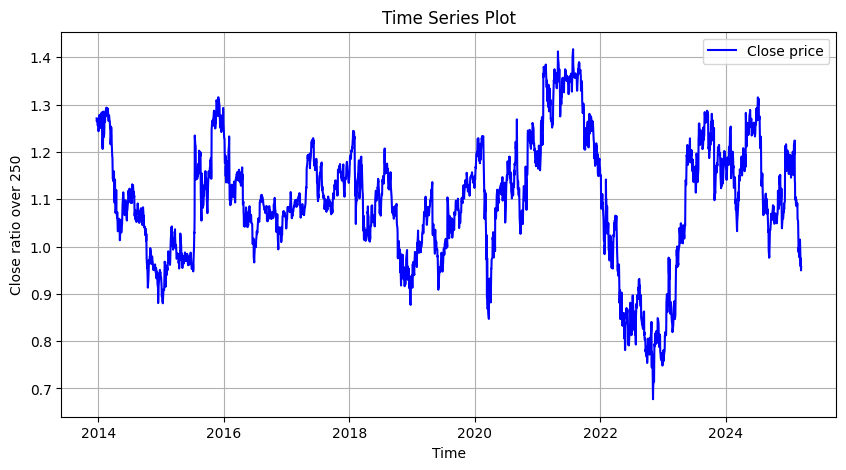

In [50]:
n_days = 250

plt.figure(figsize=(10, 5))  
plt.plot(data.index, data[f'Close_Ratio_{n_days}'], label='Close price', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel(f'Close ratio over {n_days}')
plt.title('Time Series Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

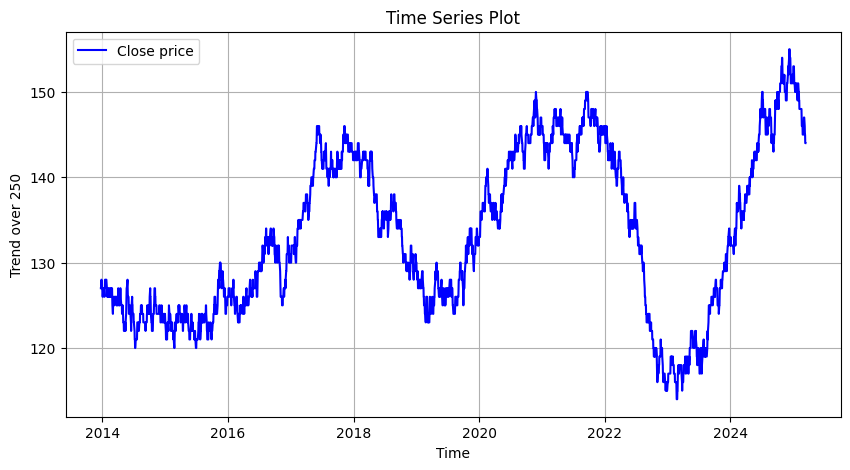

In [ ]:
plt.figure(figsize=(10, 5))  
plt.plot(data.index, data[f'Trend_{n_days}'], label='Close price', color='blue')

# Formatting
plt.xlabel('Time')
plt.ylabel(f'Trend over {n_days}')
plt.title('Jump Process Plot')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [35]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict_improved(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest_improved(data, model, predictors, start=1000, step=125):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_improved(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [36]:
predictions = backtest_improved(data, model, new_predictors)

In [37]:
predictions["Predictions"].value_counts()

Predictions
0.0    1490
1.0     333
Name: count, dtype: int64

In [38]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5465465465465466

In [32]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.541415
0    0.458585
Name: count, dtype: float64

#### Signature based model

In [52]:
import iisignature

ModuleNotFoundError: No module named 'iisignature'